[*********************100%%**********************]  7 of 7 completed
/var/folders/q9/1h42_3tn705_j_750qfm6dz00000gn/T/ipykernel_95663/3233771944.py:23: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = tickers_data.pct_change()


Optimal portfolio weights: [0.    0.    0.    0.    0.729 0.    0.271]
Optimal Sharpe ratio: -0.1670761670761671


0.6562161066034691

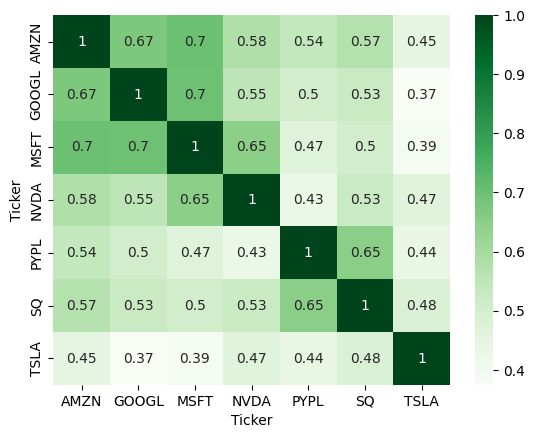

In [57]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math

# 7 Assets (Nvidia, Amazon, Google, Paypal, Microsoft Corp., Square Inc., Tesla Inc)
tickers = ['NVDA', 'AMZN', 'GOOGL', 'PYPL', 'MSFT', 'SQ', 'TSLA']

tickers = [ticker.upper() for ticker in tickers]  # alphabetize the stocks in dataframe

# Gathers asset's data from past 2 years (730 days) to today
start_date = dt.datetime.today() - pd.Timedelta(730, "d")
end_date = dt.datetime.today()

# Downloads stock data
tickers_data = yf.download(start=start_date, end=end_date, tickers=tickers)['Adj Close']
tickers_data.head()

daily_returns = tickers_data.pct_change()

# Asset's mean
mean_returns = daily_returns.mean()

# Asset's variance
variance = daily_returns.var()

# Correlation matrix
corMatrix = daily_returns.corr()
sns.heatmap(corMatrix, cmap= 'Greens', annot= True)

#--------------------------------Monte Carlo simulation------------------------------------
T= 1.0
M = 252  # Time (days)
I = 80000  # The number of portfolios to be simulated

#From pdf pg 321 (pg 299 on actual book pg): monte carlo simulation, used numpy version because it runs faster. 
def mcs_simulation_np(p):
    M, I = p
    dt = T / M
    S0 = tickers_data.iloc[-1].values  # Latest stock prices 
    S = np.zeros((M + 1, I, len(tickers)))  # Adjust the shape of S
    S[0] = S0
    rn = np.random.standard_normal(S.shape)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((mean_returns.values - 0.5 * variance.values) * dt +
                                  np.sqrt(variance.values * dt) * rn[t])
    return S

S = mcs_simulation_np((M, I)) #runs simulation


# ------------------Calculates portfolio returns and volatilities (pg 420)
def portfolio_returns(weights):
    return np.sum(daily_returns.mean() * weights) * 252
def portfolio_volatilities(weights):
    return np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))

p_returns =[]
p_volatilities = []

for i in range(I):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)  # Normalize weights to sum up to 1
    p_returns.append(portfolio_returns(weights))
    p_volatilities.append(portfolio_volatilities(weights))
    
p_returns = np.array(p_returns)
p_volatilities=np.array(p_volatilities)

#---------------------------Optimal Portfolio (pg 422)
import scipy.optimize as sco
def min_func_sharpe(weights):
    return portfolio_returns(weights)/portfolio_volatilities(weights)

cons= ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(len(tickers)))
eweights = np.array(len(tickers) * [1. / len(tickers),])

# Maximization of the Sharpe ratio
opts = sco.minimize(min_func_sharpe, eweights,method='SLSQP', bounds= bnds,constraints= cons)

optimal_port_weight= opts['x'].round(3) #sum of weights must = 1!
print("Optimal portfolio weights:", optimal_port_weight)
optimal_returns = portfolio_returns(opts['x']).round(3)
optimal_volatility = portfolio_volatilities(opts['x']).round(3)
opt_sharpe_ratio = optimal_returns / optimal_volatility

print('Optimal Sharpe ratio:', opt_sharpe_ratio)

# Minimization of the variance
optv = sco.minimize(portfolio_volatilities, eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv['x'].round(3)
portfolio_volatilities(optv['x']).round(3)
portfolio_returns(optv['x']).round(3)
portfolio_returns(optv['x']) / portfolio_volatilities(optv['x'])

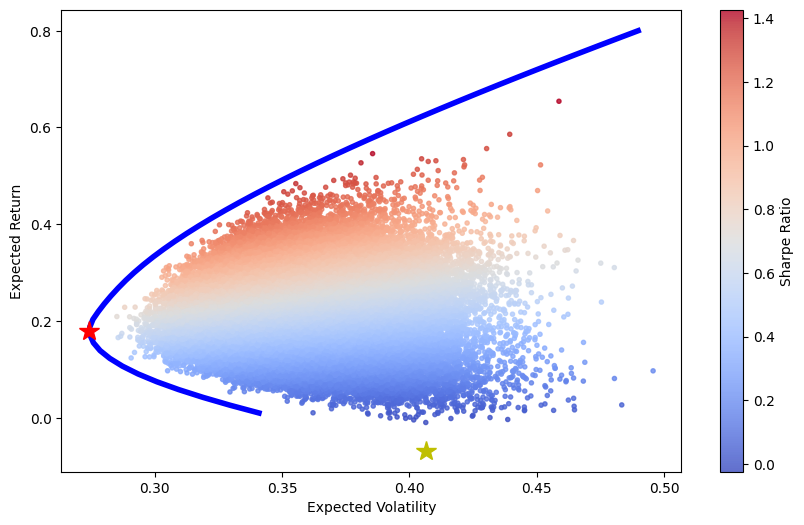

In [58]:
#----------------Efficient Frontier (pg 424)

cons = ({'type': 'eq', 'fun': lambda x: portfolio_returns(x) - tret}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)
    
trets = np.linspace(0.01, .8, 50) #target returns level
tvols = []

for tret in trets:
    res = sco.minimize(portfolio_volatilities, eweights, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

plt.figure(figsize=(10, 6))
plt.scatter(p_volatilities, p_returns, c= p_returns / p_volatilities, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(portfolio_volatilities(opts['x']), portfolio_returns(opts['x']),'y*', markersize=15.0)
plt.plot(portfolio_volatilities(optv['x']), portfolio_returns(optv['x']), 'r*', markersize=15.0)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
